In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten, CuDNNLSTM, Bidirectional, Input, GlobalAveragePooling1D
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, concatenate
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/train.csv')
test_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/test.csv')

In [4]:
train_df = pd.read_csv('processed_train.csv')
test_df = pd.read_csv('processed_test.csv')

In [5]:
train_df['target'] = train_df['target'].apply(lambda x: 0 if x <= 0.5 else 1)

In [6]:
FAST_TEXT = '/home/luis/ml-data/crawl-300d-2M.vec'
GLOVE = '/home/luis/ml-data/glove.840B.300d.txt'

In [7]:
def get_embedding_matrix(mat_type):
    if mat_type == 'fasttext':
        embeddings_index = {}
        with codecs.open(FAST_TEXT, encoding='utf-8') as f:
            for line in tqdm(f):
                values = line.rstrip().rsplit(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        return embeddings_index
    elif mat_type == 'glove':
        tdf = pd.read_csv(GLOVE, sep=" ", index_col=0, 
                               header=None, quoting=csv.QUOTE_NONE)
        return dict(zip(tdf.index, tdf.values))

In [8]:
embeddings_index = get_embedding_matrix('glove')

In [9]:
y_train = train_df['target'].values

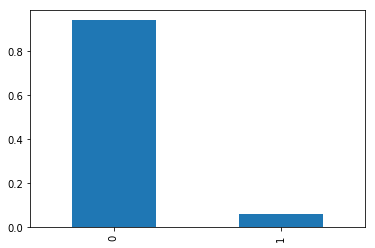

In [10]:
train_df['target'].value_counts(normalize=True).plot(kind='bar')

In [11]:
train_df.loc[(train_df['rating'] == 'rejected') & 
             (train_df['obscene'] > 0.1) & (train_df['severe_toxicity'] > 0), 'target'] = 1

In [10]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 

In [11]:
from spacy.lang.en import English
nlp = English()

In [12]:
processed_docs_train = []
for doc in tqdm(nlp.pipe(raw_docs_train)):
    processed_docs_train.append(' '.join([tok.lemma_ for tok in doc]))

1804874it [12:49, 2344.50it/s]


In [13]:
processed_docs_test = []
for doc in tqdm(nlp.pipe(raw_docs_test)):
    processed_docs_test.append(' '.join([tok.lemma_ for tok in doc]))

97320it [00:37, 2567.38it/s]


In [19]:
train_df['processed_comment_text'] = processed_docs_train
test_df['processed_comment_text'] = processed_docs_test
train_df.to_csv('processed_train.csv', index=False)
test_df.to_csv('processed_test.csv', index=False)

In [12]:
processed_docs_train = train_df['processed_comment_text'].tolist()
processed_docs_test = test_df['processed_comment_text'].tolist() 

In [13]:
print("tokenizing input data...")
tokenizer = Tokenizer(lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  315829


In [14]:
seq_lens = list(map(lambda x: len(x), word_seq_train))
empty_sequences = len(list(filter(lambda x: x == 0, seq_lens)))
print("Number of empty sequences in training:", empty_sequences)

Number of empty sequences in training: 220


In [15]:
MAX_SEQ_LEN = max(seq_lens)
VOCAB_SIZE = len(word_index)
EMBEDDED_DIMS = 300 

In [16]:
#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=MAX_SEQ_LEN)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=MAX_SEQ_LEN)

In [17]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDED_DIMS))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 170436


In [18]:
LSTM_SEQ_LEN = 240

words = Input(shape=(None,))
x = Embedding(VOCAB_SIZE, EMBEDDED_DIMS,
          weights=[embedding_matrix], input_length=MAX_SEQ_LEN, trainable=False)(words)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNLSTM(LSTM_SEQ_LEN, return_sequences=True))(x)
hidden = concatenate([GlobalMaxPooling1D()(x), GlobalAveragePooling1D()(x)])
hidden = Dense(LSTM_SEQ_LEN*4, activation='relu')(hidden)
result = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=words, outputs=result)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: name 'adam' is not defined

In [ ]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=256, epochs=16, 
                 validation_split=0.025, shuffle=True, verbose=1)

In [72]:
y_test = model.predict(word_seq_test)

In [73]:
#create a submission
submission_df = pd.DataFrame(columns=['id'])
submission_df['id'] = test_df['id'].values 
submission_df['prediction'] = y_test 
submission_df.to_csv("./rnn_fasttext_submission.csv", index=False)

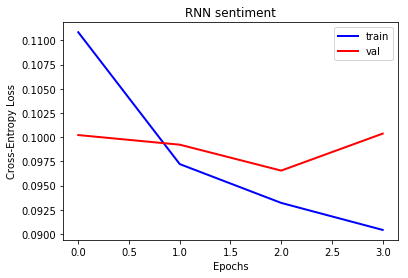

In [74]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

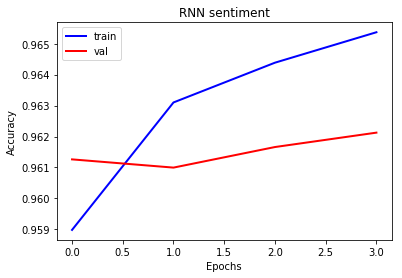

In [75]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()